### Functions and Packages

In [1]:
import numpy as np
np.set_printoptions(precision = 4, suppress = True)

In [2]:
def initialize_qtable(N, num_actions, feedback):
    if feedback == 1:
        Q = np.random.uniform(0,1,(N, num_actions,num_actions))
    else:
        Q = np.random.uniform(0,1,(N, num_actions))   
        #Q = np.zeros((N, num_actions))   
    return Q

In [3]:
def exploratory_strategy(Q, N, egreedy, num_actions,past_win,winning_bid,eps,beta):
    # Input: Master Q table, agent index, past winning action
    # Output: actions taken by all agents
    actions = np.ones(N,dtype=int)
    for agent_idx in range(N):
        if egreedy == 1:
            if past_win == 1:
                if np.random.uniform()>eps:
                    actions[agent_idx] = np.argmax(Q[agent_idx,winning_bid])
                else:
                    actions[agent_idx] = np.random.choice(range(num_actions))
            else:
                if np.random.uniform()>eps:
                    actions[agent_idx] = np.argmax(Q[agent_idx])
                else:
                    actions[agent_idx] = np.random.choice(range(num_actions))
        else: 
            if past_win == 1:
                max_Q = np.max(Q[agent_idx,winning_bid])
                logits = (Q[agent_idx,winning_bid] - max_Q) / beta
                exp_logits = np.exp(logits)
                probs = exp_logits / np.sum(exp_logits)
                actions[agent_idx] = np.random.choice(range(len(probs)), p=probs)
            else:
                max_Q = np.max(Q[agent_idx])
                logits = (Q[agent_idx] - max_Q) / beta
                exp_logits = np.exp(logits)
                probs = exp_logits / np.sum(exp_logits)
                actions[agent_idx] = np.random.choice(range(len(probs)), p=probs)    
    return actions

In [4]:
def actions2rewards(actions, valuations, design, action2bid, method=0):
    # compute winners and winning payments
    bids = action2bid[actions]
    unique_values_sorted = np.sort(np.unique(bids))[::-1]
    first_highest_value = unique_values_sorted[0]
    if len(unique_values_sorted) > 1:
        second_highest_value = unique_values_sorted[1]
    else:
        second_highest_value = first_highest_value
    winners_payment = design * first_highest_value + (1-design) * second_highest_value
    winners_idx = np.where(bids == first_highest_value)[0]
    # compute reward vector
    if method==0:
        winner_idx = np.random.choice(winners_idx)
        rewards = bids * 0.0
        rewards[winner_idx] = valuations[winner_idx] - winners_payment
    else:
        winning_bid_idx = np.where(bids==first_highest_value,1,0)
        no_of_winners = np.sum(winning_bid_idx)
        rewards = (1/no_of_winners) * (valuations - winners_payment) * winning_bid_idx 
    return rewards

In [5]:
def counterfactual_reward(agent_idx,actions,valuations,design,num_actions,action2bid):
    action_copy = actions.copy()
    cf_rewards = np.zeros(num_actions)
    for agent_action in range(num_actions):
        action_copy[agent_idx] = agent_action
        cf_rewards[agent_action] = actions2rewards(action_copy,valuations,design,action2bid,method=1)[agent_idx]
    return np.array(cf_rewards)

In [6]:
def update_qvalues(rewards, actions, Q, feedback, asynchronous, winning_bid, alpha, gamma, valuations,design,action2bid):
    N = Q.shape[0]
    num_actions = Q.shape[1]
    for agent_idx in range(N):
        action = actions[agent_idx]
        reward = rewards[agent_idx]
        if asynchronous == 1:
            if feedback == 1:
                Q[agent_idx,winning_bid,action] =  (1-alpha)*Q[agent_idx,winning_bid,action] + alpha * (reward + gamma * np.max(Q[agent_idx,winning_bid]))
            else:
                Q[agent_idx,action] =  (1-alpha)*Q[agent_idx,action] + alpha * (reward + gamma * np.max(Q[agent_idx]))
        else: 
            reward_vec = counterfactual_reward(agent_idx,actions,valuations,design,num_actions,action2bid)
            if feedback == 1:
                Q[agent_idx,winning_bid,:] =  (1-alpha)*Q[agent_idx,winning_bid,:] + alpha * (reward_vec + gamma * np.max(Q[agent_idx,winning_bid]))
            else:
                Q[agent_idx] =  (1-alpha)*Q[agent_idx] + alpha * (reward_vec + gamma * np.max(Q[agent_idx]))
    return Q

In [7]:
def experiment(N,alpha,gamma,egreedy,asynchronous,design,feedback,num_actions,decay,verbose=2):
    Q = initialize_qtable(N, num_actions,feedback)
    common_valuation = 1
    valuations = np.ones(N)*common_valuation
    action2bid = np.linspace(0,common_valuation,num_actions)
    initial_eps = 1.0
    eps_decay = decay
    min_eps = 0.01
    eps = initial_eps
    initial_beta = 1.0
    beta_decay = decay
    min_beta = 0.01
    beta = initial_beta
    winning_bid_history = []
    num_episodes = 250000
    winning_action = 0
    action_history = []
    
    print('Bidders:',N)
    print('Learning rate:',alpha)
    print('Discount factor:',gamma)
    print('eGreedy',egreedy)
    print('Asynchronous',asynchronous)
    print('First price:',design)
    print('Feedback:',feedback)
    print('Bid space:',action2bid)
    print('Q-table shape:',Q.shape)
    print('Epsilon: initial, final and decay rate', initial_eps, min_eps, eps_decay)
    print('Beta: initial, final and decay rate', initial_beta, min_beta, beta_decay)
    print('Num episodes:', num_episodes)

    # training loop
    for episode in range(num_episodes):
        
        # act from exploratory strategy
        actions = exploratory_strategy(Q, N, egreedy, num_actions,feedback,winning_action,eps,beta) 

        # collect rewards
        rewards = actions2rewards(actions,valuations,design,action2bid)
        
        # update Q-values
        Q = update_qvalues(rewards, actions, Q, feedback, asynchronous, winning_action, alpha, gamma, valuations,design,action2bid)

        # update exploration params
        eps = max(min_eps, eps * eps_decay)
        beta = max(min_beta, beta * beta_decay)

        # winning bid and action
        bids = actions*common_valuation/(num_actions-1)
        winning_bid = np.max(bids)
        winning_action = np.max(actions)

        # store history
        winning_bid_history.append(winning_bid)
        action_history.append(action2bid[actions])
        
        if (verbose==1) & (episode%10000==0) & (episode>0):
            print(episode,np.round(eps,2),np.round(beta,2),np.round(np.mean(winning_bid_history[-1000:]),2),np.round(np.std(winning_bid_history[-1000:]),2))
                
        if (verbose==2) & (episode%10000==0) & (episode>0):
            #action_history.append(actions)
            print('\nEpisode:',episode,np.round(eps,3))
            print('Bids:',action2bid[actions],', Rewards:',rewards)
            #print(winning_bid_history[-20:])
            print('Agent 0:',Q[0,:])
            #print('Agent 0 Cf reward', counterfactual_reward(0,actions,valuations,design,num_actions,action2bid))
            print('Agent 1:',Q[1,:])
            #print('Agent 1 Cf reward', counterfactual_reward(1,actions,valuations,design,num_actions,action2bid))
            print('Stdev of last 10000 bids:',np.std(winning_bid_history[-10000:]))
            print('Avg of last 10000 bids:',np.mean(winning_bid_history[-10000:]))
            
        if (episode%10000==0) & (eps==min_eps or beta==min_beta) & (np.std(winning_bid_history[-1000:])<0.001):
            break

    Y = np.mean(winning_bid_history[-1000:])
    Y_std = np.std(winning_bid_history[-1000:])
    Y_min = np.min(winning_bid_history[-1000:])
    Y_max = np.max(winning_bid_history[-1000:])
    
    if verbose==2:
        return (Y,episode,Y_std,Y_min,Y_max,N,alpha,gamma,egreedy,asynchronous,design,feedback,num_actions,decay,action_history,winning_bid_history)
    else:
        return (Y,episode,Y_std,Y_min,Y_max,N,alpha,gamma,egreedy,asynchronous,design,feedback,num_actions,decay,Q)





### Test Cases

In [8]:
params = {'N': 4, 'alpha': 0.1, 'gamma': 0.99, 'egreedy': 0, 'design': 0, 
          'asynchronous': 1, 'feedback': 1, 'num_actions': 6, 'decay':0.9999, 'verbose':2}


(Y,episode,Y_std,Y_min,Y_max,N,alpha,gamma,egreedy,asynchronous,design,feedback,num_actions,decay,action_history,winning_bid_history) = experiment(**params)



Bidders: 4
Learning rate: 0.1
Discount factor: 0.99
eGreedy 0
Asynchronous 1
First price: 0
Feedback: 1
Bid space: [0.  0.2 0.4 0.6 0.8 1. ]
Q-table shape: (4, 6, 6)
Epsilon: initial, final and decay rate 1.0 0.01 0.9999
Beta: initial, final and decay rate 1.0 0.01 0.9999
Num episodes: 250000

Episode: 10000 0.368
Bids: [1. 1. 1. 1.] , Rewards: [0. 0. 0. 0.]
Agent 0: [[ 0.5951  0.4733  0.8948  0.5243  0.6749  0.8912]
 [ 0.7038  0.7973  0.786   0.9981  0.956   1.0057]
 [ 1.4676  1.6374  1.6431  1.5955  1.7847  1.8849]
 [ 3.4644  3.4291  3.5628  3.5127  3.6122  3.7639]
 [10.2504  9.7417  9.8652 10.1185 10.4966 10.4912]
 [20.4793 20.4952 20.526  20.4895 20.6091 20.7687]]
Agent 1: [[ 0.9783  0.0375  0.2181  0.3292  0.2873  0.6309]
 [ 0.5631  0.4605  0.7408  0.8447  0.401   0.6826]
 [ 1.1739  1.295   1.2637  1.3226  1.5378  1.4452]
 [ 5.4613  5.7348  4.676   4.3891  6.3569  6.5577]
 [ 8.8321  8.8437  8.8059  8.8214  8.8856  8.9204]
 [18.7736 18.7901 18.8884 18.8316 18.9707 19.0301]]
Stdev o

### Visualize the learning process

In [9]:

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (50, 10)
plt.rcParams['font.size']=30
plt.rc('legend', fontsize=30)
plt.style.use('ggplot')
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [10]:
params = {'N': 4, 'alpha': 0.1, 'gamma': 0.99, 'egreedy': 0, 'design': 0, 
          'asynchronous': 1, 'feedback': 1, 'num_actions': 6, 'decay':0.99999, 'verbose':2}


(Y,episode,Y_std,Y_min,Y_max,N,alpha,gamma,egreedy,asynchronous,design,feedback,num_actions,decay,action_history,winning_bid_history) = experiment(**params)
action_history = np.array(action_history)
winning_bid_history = np.array(winning_bid_history)
plt.plot(moving_average(action_history[:130001,0],1000), label = 'Bidder 1', c = 'blue')
plt.plot(moving_average(action_history[:130001,1],1000), label = 'Bidder 2', c = 'green')
plt.plot(moving_average(action_history[:130001,2],1000), label = 'Bidder 3', c = 'orange')
plt.plot(moving_average(action_history[:130001,3],1000), label = 'Bidder 4', c = 'red')
plt.plot(moving_average(winning_bid_history[:130001],1000), label = 'Winning Bid', c = 'black')
plt.legend()
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.savefig('second-price-visual.png', dpi=300, bbox_inches='tight')
plt.show()


Bidders: 4
Learning rate: 0.1
Discount factor: 0.99
eGreedy 0
Asynchronous 1
First price: 0
Feedback: 1
Bid space: [0.  0.2 0.4 0.6 0.8 1. ]
Q-table shape: (4, 6, 6)
Epsilon: initial, final and decay rate 1.0 0.01 0.99999
Beta: initial, final and decay rate 1.0 0.01 0.99999
Num episodes: 250000

Episode: 10000 0.905
Bids: [0.  0.4 0.4 0.8] , Rewards: [0.  0.  0.  0.6]
Agent 0: [[ 0.1222  0.407   0.117   0.3281  0.4164  0.4127]
 [ 0.7773  0.9823  0.9291  1.141   0.2795  0.8776]
 [ 2.4974  2.3226  2.5054  2.4442  2.483   2.7295]
 [ 5.5695  5.7454  5.7722  5.7505  6.1927  5.9616]
 [11.8887 11.9532 11.8112 11.9523 11.9318 12.0942]
 [19.5493 19.5073 19.6312 19.6523 19.7123 19.8466]]
Agent 1: [[ 0.5155  0.0357  0.1777  0.3246  0.7226  0.6679]
 [ 1.0491  0.956   0.9757  0.9024  1.2432  1.1793]
 [ 2.1992  2.4964  2.7863  2.5694  2.8472  2.9759]
 [ 5.2386  5.1396  5.2482  5.3655  5.4948  5.4673]
 [12.2795 12.282  12.498  12.3619 12.4122 12.7012]
 [20.2058 20.1868 20.1691 20.2228 20.2365 20.5379

KeyboardInterrupt: 

Bidders: 4
Learning rate: 0.1
Discount factor: 0.99
eGreedy 0
Asynchronous 1
First price: 1
Feedback: 1
Bid space: [0.  0.2 0.4 0.6 0.8 1. ]
Q-table shape: (4, 6, 6)
Epsilon: initial, final and decay rate 1.0 0.01 0.9999
Beta: initial, final and decay rate 1.0 0.01 0.9999
Num episodes: 250000

Episode: 10000 0.368
Bids: [0.4 0.8 0.8 0. ] , Rewards: [0.  0.2 0.  0. ]
Agent 0: [[0.0472 0.9301 0.5336 0.2299 0.3988 0.4084]
 [0.7789 0.9041 0.8455 0.9338 0.8886 0.7251]
 [1.5492 1.549  1.6499 1.6999 1.6924 1.5672]
 [2.2506 2.3409 2.3754 2.3532 2.4034 2.2829]
 [4.9723 4.9887 5.0136 5.0798 5.0683 4.9994]
 [6.3488 6.3752 6.3487 6.4531 6.4543 6.3523]]
Agent 1: [[0.9072 0.9701 0.8995 0.5766 0.6944 0.5477]
 [0.5138 0.4768 0.9108 0.9418 0.9783 0.9249]
 [1.589  1.605  1.6654 1.6495 1.6917 1.6273]
 [2.5468 2.5166 2.6095 2.6017 2.6401 2.5372]
 [4.9592 4.9309 4.9985 5.0745 5.1109 4.9473]
 [6.2172 6.2379 6.2445 6.3076 6.3352 6.2233]]
Stdev of last 10000 bids: 0.18391060328322562
Avg of last 10000 bids: 0

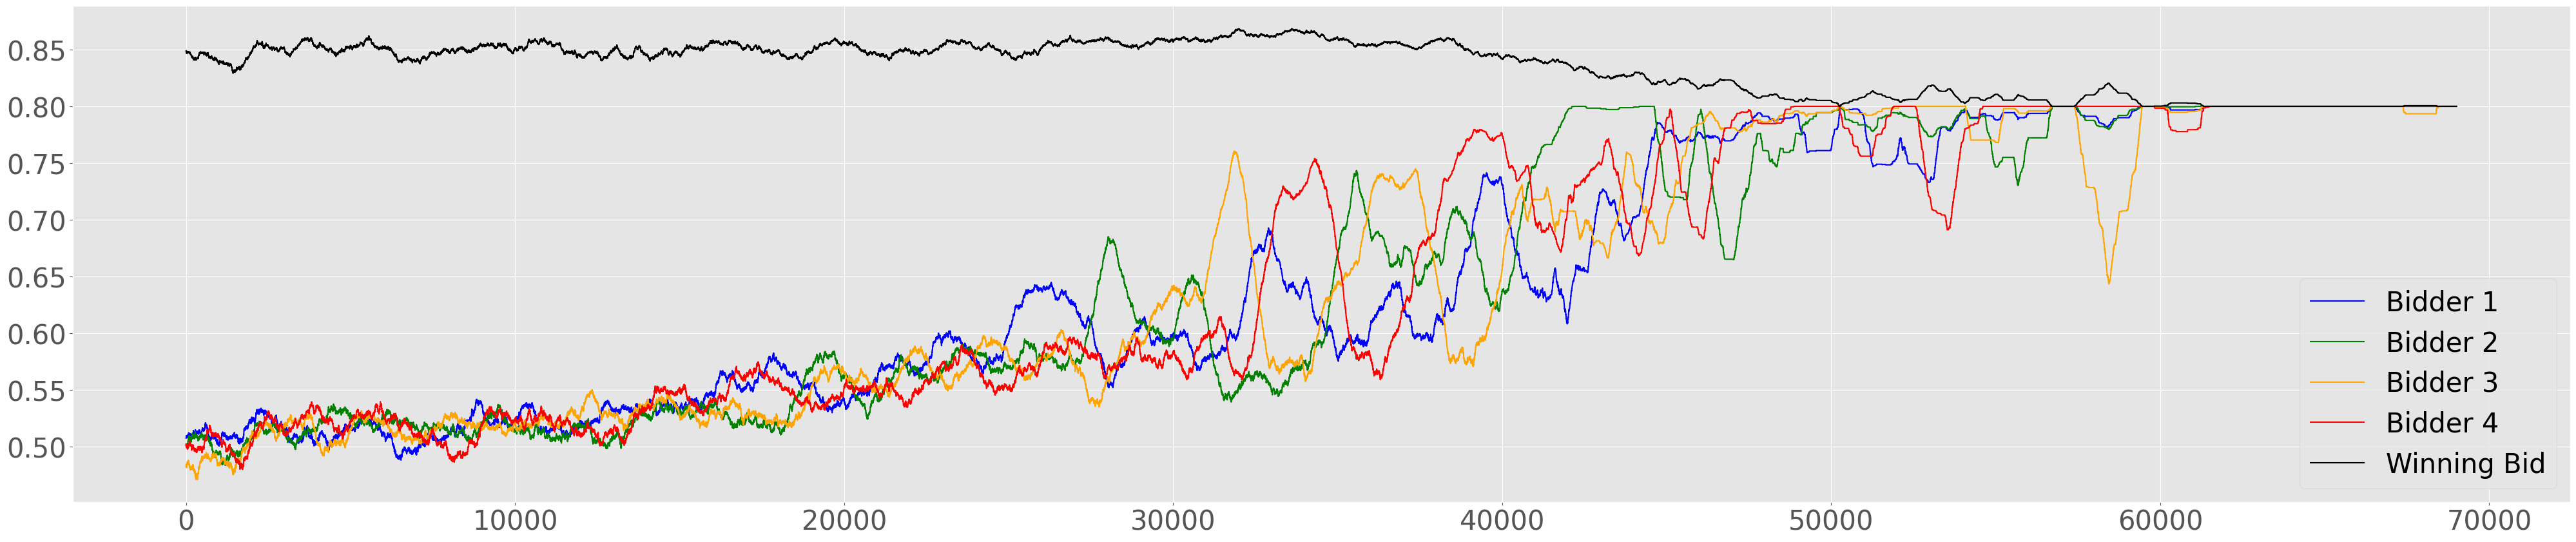

In [11]:
params = {'N': 4, 'alpha': 0.1, 'gamma': 0.99, 'egreedy': 0, 'design': 1, 
          'asynchronous': 1, 'feedback': 1, 'num_actions': 6, 'decay':0.99999, 'verbose':2}

(Y,episode,Y_std,Y_min,Y_max,N,alpha,gamma,egreedy,asynchronous,design,feedback,num_actions,decay,action_history,winning_bid_history) = experiment(**params)

action_history = np.array(action_history)
winning_bid_history = np.array(winning_bid_history)

plt.plot(moving_average(action_history[:130001,0],1000), label = 'Bidder 1', c = 'blue')
plt.plot(moving_average(action_history[:130001,1],1000), label = 'Bidder 2', c = 'green')
plt.plot(moving_average(action_history[:130001,2],1000), label = 'Bidder 3', c = 'orange')
plt.plot(moving_average(action_history[:130001,3],1000), label = 'Bidder 4', c = 'red')
plt.plot(moving_average(winning_bid_history[:130001],1000), label = 'Winning Bid', c = 'black')
plt.legend()
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.savefig('first-price-visual.png', dpi=300, bbox_inches='tight')
plt.show()

### Random Sampling

In [12]:
import random

parameters = {'N':[2,4,6,8,10],
              'alpha':[0.01,0.05,0.1,0.5],
              'gamma':[0.0,0.25, 0.5, 0.75, 0.99],
              'egreedy':[0,1],
              'design':[0.0, 0.25, 0.5, 0.75,1.0],
              'asynchronous':[0,1],
              'feedback':[0,1],
              'num_actions':[6,21,31,51],
              'decay':[0.999,0.9995,0.9999,0.99995,0.99999],
              'verbose':[1]
             }

K = 1000 # Number of times to sample
data = []
for _ in range(K):
    sampled_params = {}
    for key, value in parameters.items():
        if isinstance(value, list):
            sampled_params[key] = random.choice(value)
        else:
            sampled_params[key] = value
    
    print(sampled_params)
    (Y,episode,Y_std,Y_min,Y_max,N,alpha,gamma,egreedy,asynchronous,design,feedback,num_actions,decay,Q) = experiment(**sampled_params)
    data.append((Y,episode,Y_std,Y_min,Y_max,N,alpha,gamma,egreedy,asynchronous,design,feedback,num_actions,decay))
    print((_,Y,episode,Y_std))
    print("-" * 20)

{'N': 10, 'alpha': 0.1, 'gamma': 0.99, 'egreedy': 0, 'design': 0.5, 'asynchronous': 1, 'feedback': 1, 'num_actions': 31, 'decay': 0.999, 'verbose': 1}
Bidders: 10
Learning rate: 0.1
Discount factor: 0.99
eGreedy 0
Asynchronous 1
First price: 0.5
Feedback: 1
Bid space: [0.     0.0333 0.0667 0.1    0.1333 0.1667 0.2    0.2333 0.2667 0.3
 0.3333 0.3667 0.4    0.4333 0.4667 0.5    0.5333 0.5667 0.6    0.6333
 0.6667 0.7    0.7333 0.7667 0.8    0.8333 0.8667 0.9    0.9333 0.9667
 1.    ]
Q-table shape: (10, 31, 31)
Epsilon: initial, final and decay rate 1.0 0.01 0.999
Beta: initial, final and decay rate 1.0 0.01 0.999
Num episodes: 250000
10000 0.01 0.01 1.0 0.0
(0, 1.0, 10000, 0.0)
--------------------


### Data Collection

In [14]:
import pandas as pd
df = pd.DataFrame(data, columns = ['bid2val','episode','Y_std','Y_min','Y_max','N','alpha','gamma','egreedy','asynchronous','design','feedback','num_actions','decay'])
df.to_pickle('data_experiment_main.pkl')

In [16]:
import pandas as pd
df3 = pd.read_pickle('data_experiment_main.pkl')

In [20]:
df3.to_csv('data_experiment_main.csv')

In [21]:
df3.columns = ['bid2val','episodes','volatility','bid2val_min','bid2val_max','N','alpha','gamma','egreedy','asynchronous','design','feedback','num_actions','decay']

df3.head()

,bid2val,episodes,volatility,bid2val_min,bid2val_max,N,alpha,gamma,egreedy,asynchronous,design,feedback,num_actions,decay
0,1.0,10000,0.0,1.0,1.0,10,0.1,0.99,0,1,0.5,1,31,0.999


### Summary statistics

In [22]:
df3[['bid2val','episodes','bid2val_std','bid2val_min','bid2val_max']].describe().style.to_latex('summary_statistics1.tex')




KeyError: "['bid2val_std'] not in index"

In [23]:
a = df3[['bid2val','episodes','bid2val_std','bid2val_min','bid2val_max']].describe()
b = df3[['N','alpha','gamma','egreedy','asynchronous','design','feedback','num_actions','decay']].describe()
stargazer = Stargazer([a, b])
print(stargazer.render_latex())

KeyError: "['bid2val_std'] not in index"

In [94]:
df3[['N','alpha','gamma','egreedy','asynchronous','design','feedback','num_actions','decay']].describe().style.to_latex('summary_statistics2.tex')

<AxesSubplot: >

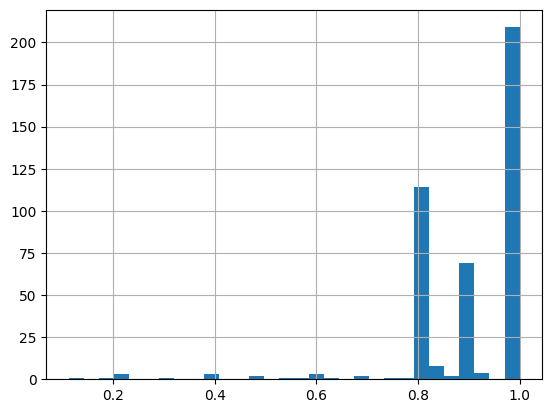

In [3]:
df3.bid2val.hist(bins=30)

<AxesSubplot: >

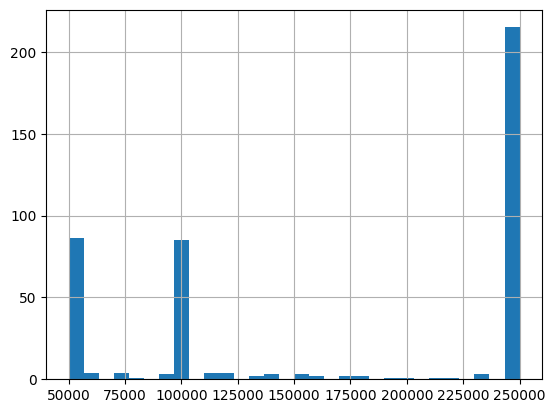

In [4]:
df3.episodes.hist(bins=30)

<AxesSubplot: >

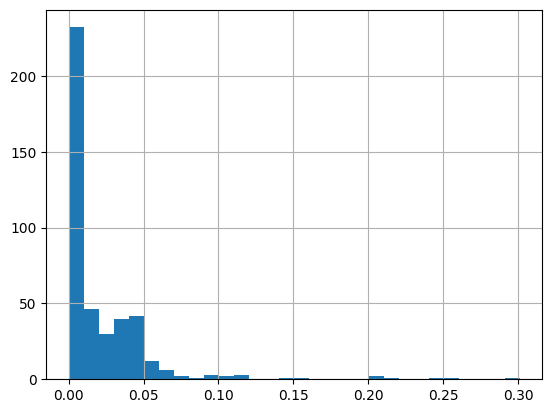

In [6]:
df3.bid2val_std.hist(bins=30)

<AxesSubplot: >

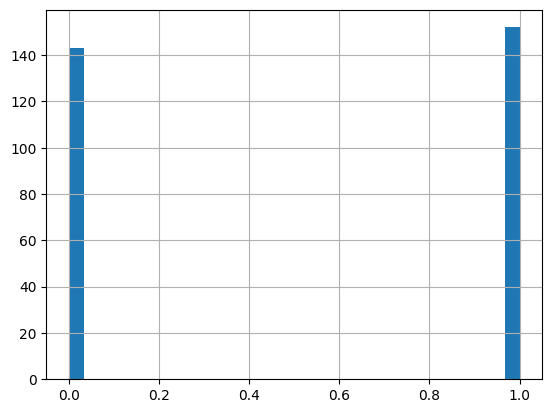

In [161]:
df3.asynchronous.hist(bins=30)

<AxesSubplot: >

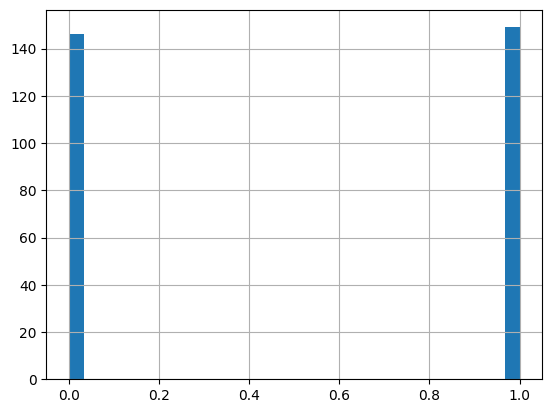

In [162]:
df3.design.hist(bins=30)

<AxesSubplot: >

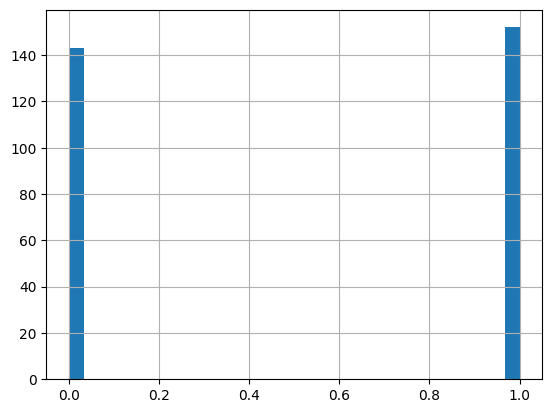

In [163]:
df3.asynchronous.hist(bins=30)

In [7]:
df3.shape

(14, 14)

### Box plots

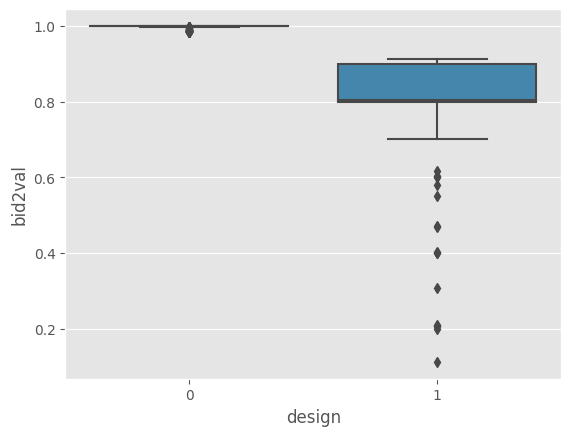

In [31]:
import seaborn as sns
import matplotlib
matplotlib.style.use('ggplot')
sns_plot = sns.boxplot(data=df3, x="design", y="bid2val")
fig = sns_plot.get_figure()
fig.savefig("boxplot_bid2val.png")

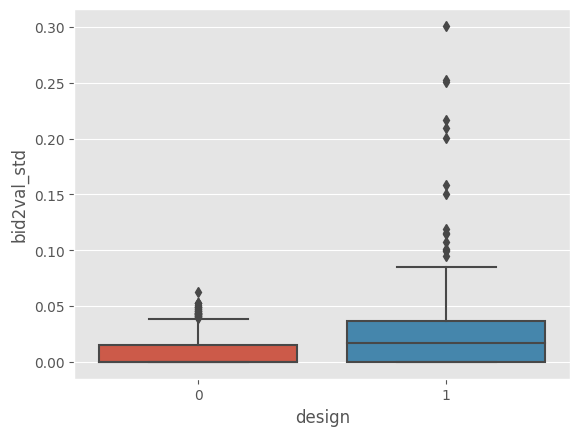

In [32]:
import seaborn as sns
import matplotlib
matplotlib.style.use('ggplot')
sns_plot = sns.boxplot(data=df3, x="design", y="bid2val_std")
fig = sns_plot.get_figure()
fig.savefig("boxplot_vol.png")

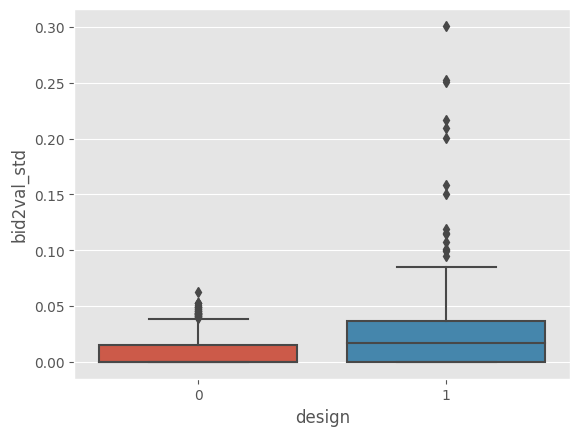

In [8]:
import seaborn as sns
import matplotlib
matplotlib.style.use('ggplot')
sns_plot = sns.boxplot(data=df3, x="design", y="bid2val_std")
fig = sns_plot.get_figure()
fig.savefig("boxplot.png")

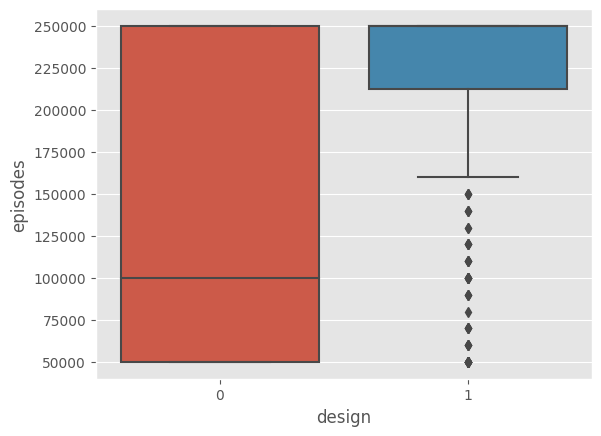

In [9]:
import seaborn as sns
import matplotlib
matplotlib.style.use('ggplot')
sns_plot = sns.boxplot(data=df3, x="design", y="episodes")
fig = sns_plot.get_figure()
fig.savefig("boxplot.png")

In [85]:
df3.describe().to_latex('summary_statistics.tex')

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


### Regression

In [75]:
pip install stargazer


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: /usr/local/opt/python@3.10/bin/python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [13]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from stargazer.stargazer import Stargazer

est1 = smf.ols('bid2val ~ design', data =df3).fit()
est2 = smf.ols('bid2val ~ design + N + alpha + gamma + egreedy + asynchronous + feedback + num_actions + decay', data =df3).fit()
est3 = smf.ols('bid2val ~ N + alpha + gamma + egreedy + asynchronous + design + feedback + num_actions + decay + design:N + design:alpha + design:gamma + design:egreedy + design:asynchronous + design:feedback + design:num_actions + design:decay', data =df3).fit()
stargazer = Stargazer([est1, est2,est3],se = None)
print(stargazer.render_latex())

TypeError: Stargazer.__init__() got an unexpected keyword argument 'se'

In [10]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from stargazer.stargazer import Stargazer

est1 = smf.ols('bid2val_std ~ design', data =df3).fit()
est2 = smf.ols('bid2val_std ~ design + N + alpha + gamma + egreedy + asynchronous + feedback + num_actions + decay', data =df3).fit()
#est3 = smf.ols('bid2val ~ N + alpha + gamma + egreedy + asynchronous + design + feedback + num_actions + decay + design:N + design:alpha + design:gamma + design:egreedy + design:asynchronous + design:feedback + design:num_actions + design:decay', data =df3).fit()
stargazer = Stargazer([est1, est2])
print(stargazer.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lcc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{2}{c}{\textit{Dependent variable:}} \
\cr \cline{2-3}
\\[-1.8ex] & (1) & (2) \\
\hline \\[-1.8ex]
 Intercept & 0.010$^{***}$ & -139.829$^{**}$ \\
  & (0.002) & (62.448) \\
 N & & -0.010$^{***}$ \\
  & & (0.002) \\
 alpha & & 0.100$^{***}$ \\
  & & (0.035) \\
 asynchronous & & 0.001$^{}$ \\
  & & (0.003) \\
 decay & & 139.853$^{**}$ \\
  & & (62.453) \\
 design & 0.020$^{***}$ & 0.021$^{***}$ \\
  & (0.003) & (0.003) \\
 egreedy & & -0.007$^{**}$ \\
  & & (0.003) \\
 feedback & & 0.008$^{**}$ \\
  & & (0.003) \\
 gamma & & 0.008$^{**}$ \\
  & & (0.003) \\
 num_actions & & 0.002$^{***}$ \\
  & & (0.001) \\
\hline \\[-1.8ex]
 Observations & 427 & 427 \\
 $R^2$ & 0.081 & 0.224 \\
 Adjusted $R^2$ & 0.078 & 0.207 \\
 Residual Std. Error & 0.035(df = 425) & 0.032(df = 417)  \\
 F Statistic & 37.288$^{***}$ (df = 1.0; 425.0) & 13.360$^{***}$ (df = 9.0; 417.0) \\
\hline
\hl

In [11]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from stargazer.stargazer import Stargazer

est1 = smf.ols('episodes ~ design', data =df3).fit()
est2 = smf.ols('episodes ~ design + N + alpha + gamma + egreedy + asynchronous + feedback + num_actions + decay', data =df3).fit()
#est3 = smf.ols('bid2val ~ N + alpha + gamma + egreedy + asynchronous + design + feedback + num_actions + decay + design:N + design:alpha + design:gamma + design:egreedy + design:asynchronous + design:feedback + design:num_actions + design:decay', data =df3).fit()
stargazer = Stargazer([est1, est2])
print(stargazer.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lcc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{2}{c}{\textit{Dependent variable:}} \
\cr \cline{2-3}
\\[-1.8ex] & (1) & (2) \\
\hline \\[-1.8ex]
 Intercept & 122248.536$^{***}$ & -855973322.698$^{***}$ \\
  & (5103.663) & (135090377.733) \\
 N & & -11287.328$^{***}$ \\
  & & (3383.278) \\
 alpha & & 42714.500$^{}$ \\
  & & (74867.618) \\
 asynchronous & & -16849.662$^{**}$ \\
  & & (6743.134) \\
 decay & & 856174164.216$^{***}$ \\
  & & (135100265.570) \\
 design & 90824.129$^{***}$ & 89211.029$^{***}$ \\
  & (7142.786) & (6778.554) \\
 egreedy & & 6707.839$^{}$ \\
  & & (6775.448) \\
 feedback & & 4220.911$^{}$ \\
  & & (6740.473) \\
 gamma & & 822.856$^{}$ \\
  & & (7174.512) \\
 num_actions & & 2398.109$^{*}$ \\
  & & (1352.458) \\
\hline \\[-1.8ex]
 Observations & 427 & 427 \\
 $R^2$ & 0.276 & 0.370 \\
 Adjusted $R^2$ & 0.274 & 0.356 \\
 Residual Std. Error & 73782.795(df = 425) & 69483.422(df = 417)  \\
 F

In [117]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
results = smf.ols('bid2val ~ N + alpha + gamma + egreedy + asynchronous + design + feedback + num_actions + decay + design:N + design:alpha + design:gamma + design:egreedy + design:asynchronous + design:feedback + design:num_actions + design:decay', data =df3).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                bid2val   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     40.97
Date:                Sat, 10 Jun 2023   Prob (F-statistic):           2.80e-77
Time:                        11:52:56   Log-Likelihood:                 459.98
No. Observations:                 427   AIC:                            -884.0
Df Residuals:                     409   BIC:                            -810.9
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              15.0220    

In [118]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
results = smf.ols('bid2val ~ design * N * alpha * gamma * egreedy * asynchronous * feedback * num_actions * decay', data =df3).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                bid2val   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     7.435
Date:                Sat, 10 Jun 2023   Prob (F-statistic):           3.51e-29
Time:                        11:53:56   Log-Likelihood:                 877.53
No. Observations:                 427   AIC:                            -1149.
Df Residuals:                     124   BIC:                             80.14
Df Model:                         302                                         
Covariance Type:            nonrobust                                         
                                                                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

### Predictive performance

In [26]:
y = df3['episodes']
X = df3.drop(['bid2val','episodes','bid2val_std','bid2val_min','bid2val_max'],axis=1)
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
# Create a Random Forest regressor
rf_regressor = RandomForestRegressor(n_estimators=500,max_depth=3)
# Define the number of folds for cross-validation
k_folds = 5
# Perform cross-validation
kf = KFold(n_splits=k_folds, shuffle=True)
cross_val_scores = cross_val_score(rf_regressor, X, y, cv=kf, scoring='r2')
# Print the performance metrics
print("Cross-validation scores:", cross_val_scores)
print("Average R-squared:", cross_val_scores.mean())

Cross-validation scores: [0.56264428 0.57192219 0.64973875 0.65388502 0.44773919]
Average R-squared: 0.5771858888549724


In [27]:
X

,N,alpha,gamma,egreedy,asynchronous,design,feedback,num_actions,decay
0,4,0.01,0.00,0,1,0,1,11,0.99990
1,2,0.01,0.95,1,0,0,0,6,0.99995
2,2,0.01,0.00,0,0,0,1,6,0.99990
3,2,0.01,0.95,0,0,0,1,11,0.99995
4,2,0.10,0.00,1,1,1,0,6,0.99990
...,...,...,...,...,...,...,...,...,...
113,2,0.10,0.00,1,0,1,0,11,0.99990
114,4,0.01,0.95,0,0,0,0,11,0.99990
115,4,0.01,0.00,0,1,0,1,11,0.99995
116,4,0.10,0.00,0,0,0,1,6,0.99995


### feature importance

In [28]:
import numpy as np
rf_regressor.fit(X, y)
# Get feature importances
importances = rf_regressor.feature_importances_

# Get the indices that would sort the importances in descending order
indices = np.argsort(importances)[::-1]

# Print feature importance ranking
print("Feature Importance Ranking:")
for i, idx in enumerate(indices):
    print(f"{i + 1}. Feature {idx + 1}: {importances[idx]}")

Feature Importance Ranking:
1. Feature 6: 0.45178548315845124
2. Feature 1: 0.39442450874212615
3. Feature 9: 0.07425013776804125
4. Feature 5: 0.05087193791908545
5. Feature 8: 0.016980569888847868
6. Feature 4: 0.004547360488928754
7. Feature 3: 0.004164551399529746
8. Feature 2: 0.0019641368564968552
9. Feature 7: 0.0010113137784926597


In [104]:
from sklearn.ensemble import RandomForestRegressor
import eli5
from eli5.sklearn import PermutationImportance
rf_regressor = RandomForestRegressor(n_estimators=100)
rf_regressor.fit(X, y)
perm_importance = PermutationImportance(rf_regressor).fit(X, y)
eli5.show_weights(perm_importance)

Weight,Feature
1.5493 ± 0.2518,x5
0.5315 ± 0.1032,x0
0.4590 ± 0.0412,x4
0.4289 ± 0.1983,x2
0.2211 ± 0.0906,x6
0.1608 ± 0.0144,x7
0.0783 ± 0.0447,x1
0.0357 ± 0.0401,x8
0.0103 ± 0.0145,x3


### Propensity Score Treatment Effect

In [106]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

X = df3.drop(['bid2val','design','episodes','bid2val_std','bid2val_min','bid2val_max'],axis=1)
T  = df3['design']
# Concatenate the treatment indicator and covariates
data = pd.concat([T, X], axis=1)

# Fit a logistic regression model to estimate propensity scores
logit_model = sm.Logit(T, X)
propensity_scores = logit_model.fit().predict(X)

# Estimate the treatment effect using propensity scores
treated_outcomes = y[T == 1]
untreated_outcomes = y[T == 0]

ATE = np.mean(treated_outcomes) - np.mean(untreated_outcomes)

# Print the estimated treatment effect
print("Average Treatment Effect (ATE):", ATE)

Optimization terminated successfully.
         Current function value: 0.685263
         Iterations 4
Average Treatment Effect (ATE): -0.19223544620517075


In [107]:
T

0      0
1      0
2      0
3      0
4      1
      ..
113    1
114    0
115    0
116    0
117    1
Name: design, Length: 427, dtype: int64

### Double Machine Learning

In [109]:
X = df3.drop(['bid2val','design','episodes','bid2val_std','bid2val_min','bid2val_max'],axis=1)
T = df3['design']
from econml.dml import LinearDML
est = LinearDML()
model = est.fit(y, T, X=X,W=None)
model.summary()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
N,0.043,0.009,4.999,0.0,0.026,0.059
alpha,-0.121,0.178,-0.678,0.498,-0.469,0.228
gamma,-0.054,0.016,-3.374,0.001,-0.085,-0.023
egreedy,-0.024,0.016,-1.495,0.135,-0.055,0.007
asynchronous,-0.063,0.016,-3.943,0.0,-0.094,-0.032
feedback,0.005,0.016,0.288,0.773,-0.026,0.035
num_actions,0.007,0.003,2.255,0.024,0.001,0.013
decay,-285.723,321.264,-0.889,0.374,-915.389,343.942
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,285.396,321.24,0.888,0.374,-344.223,915.016


In [111]:
print(model.summary().as_latex())

\begin{center}
\begin{tabular}{lcccccc}
\toprule
                         & \textbf{point\_estimate} & \textbf{stderr} & \textbf{zstat} & \textbf{pvalue} & \textbf{ci\_lower} & \textbf{ci\_upper}  \\
\midrule
\textbf{N}               &          0.043           &      0.009      &     4.999      &       0.0       &       0.026        &       0.059         \\
\textbf{alpha}           &          -0.121          &      0.178      &     -0.678     &      0.498      &       -0.469       &       0.228         \\
\textbf{gamma}           &          -0.054          &      0.016      &     -3.374     &      0.001      &       -0.085       &       -0.023        \\
\textbf{egreedy}         &          -0.024          &      0.016      &     -1.495     &      0.135      &       -0.055       &       0.007         \\
\textbf{asynchronous}    &          -0.063          &      0.016      &     -3.943     &       0.0       &       -0.094       &       -0.032        \\
\textbf{feedback}        &          

In [60]:
dir(model)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_cached_values',
 '_check_fitted_dims',
 '_check_fitted_dims_w_z',
 '_check_input_dims',
 '_d_t',
 '_d_t_in',
 '_d_w',
 '_d_x',
 '_d_y',
 '_d_z',
 '_defer_to_inference',
 '_expand_treatments',
 '_fit_final',
 '_fit_nuisances',
 '_gen_featurizer',
 '_gen_model_final',
 '_gen_model_t',
 '_gen_model_y',
 '_gen_ortho_learner_model_final',
 '_gen_ortho_learner_model_nuisance',
 '_gen_rlearner_model_final',
 '_get_inference',
 '_get_inference_options',
 '_illegal_refit_inference_methods',
 '_inference',
 '_input_names',
 '_models_nuisance',
 '_original_treatment_featurizer',
 '_ortho_learn

In [61]:
import numpy as np
import sklearn
from econml.orf import DMLOrthoForest, DROrthoForest
np.random.seed(123)
est = DMLOrthoForest(n_trees=1, max_depth=1, subsample_ratio=1,
                      model_T=sklearn.linear_model.LinearRegression(),
                    model_Y=sklearn.linear_model.LinearRegression())
est.fit(y, T, X=X, W=None)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xf
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xf
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.2s finished


In [104]:
print(est.effect(X[:2]))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xf
RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xf


[-0.1398 -1.149 ]


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.4s finished


In [177]:
from econml.orf import DMLOrthoForest
from econml.sklearn_extensions.linear_model import WeightedLasso
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(123)

est = DMLOrthoForest(n_trees=100,
                     max_depth=5,
                     model_Y=WeightedLasso(alpha=0.01),
                     model_T=WeightedLasso(alpha=0.01))
est.fit(y, T, X=X, W=None)

treatment_effects = est.effect(X)

plt.plot(X[:, 0], treatment_effects, label='ORF estimate')
plt.legend()
plt.show(block=False)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    0.3s
RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xf
RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xf
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xf
RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xf
RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xf
RuntimeError: module compiled against API version 0x10 but this ve

InvalidIndexError: (slice(None, None, None), 0)

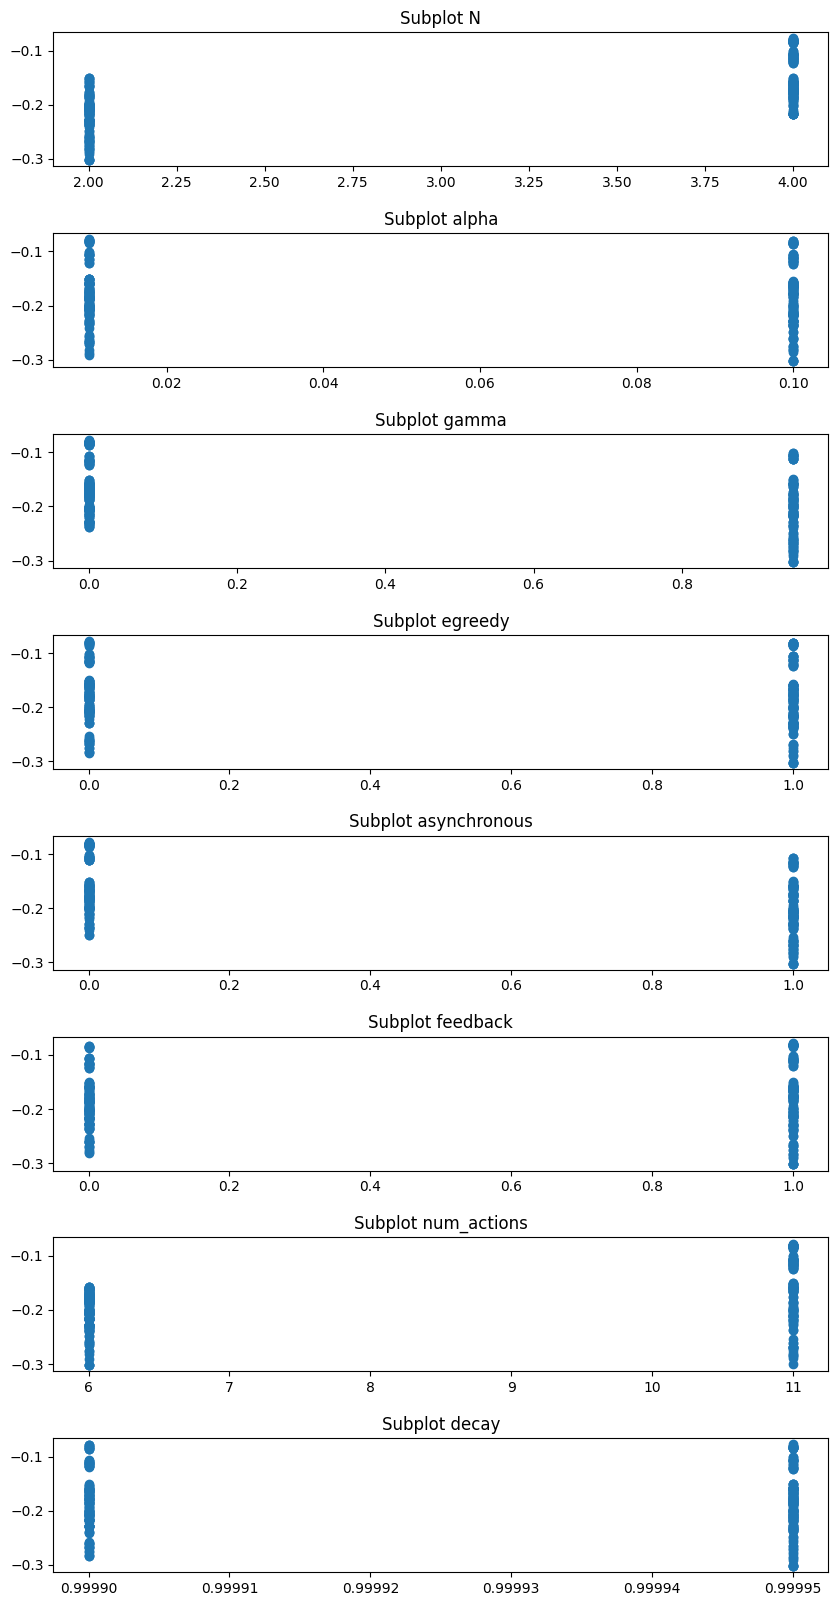

In [178]:
import matplotlib.pyplot as plt

N = 8  # Number of subplots

# Adjust the figure size
fig, axes = plt.subplots(N, 1, figsize=(10, 20))  # Change the figsize according to your desired size

# Iterate over the subplots and customize each one
for i, ax in enumerate(axes):
    # Plot some data on each subplot
    ax.scatter(X.to_numpy()[:, i], treatment_effects, label=X.columns[i])
    # Set a title for each subplot
    ax.set_title(f'Subplot {X.columns[i]}')
    
# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5)  # Change the hspace value according to your desired spacing

# Display the figure
plt.show()

### Mean comparision

In [179]:
df3.groupby('N').mean()

,bid2val,episode,Y_std,Y_min,Y_max,alpha,gamma,egreedy,asynchronous,design,feedback,num_actions,decay
N,,,,,,,,,,,,,
2,0.878578,178174.627737,0.028365,0.662774,0.944526,0.054015,0.422993,0.481752,0.547445,0.496350,0.452555,8.372263,0.999928
4,0.922938,160822.316456,0.011739,0.874684,0.994937,0.058418,0.402848,0.563291,0.487342,0.512658,0.544304,8.341772,0.999928


In [180]:
df3.groupby('alpha').mean()

,bid2val,episode,Y_std,Y_min,Y_max,N,gamma,egreedy,asynchronous,design,feedback,num_actions,decay
alpha,,,,,,,,,,,,,
0.01,0.912428,168181.300699,0.013515,0.800000,0.976923,3.020979,0.398601,0.517483,0.517483,0.503497,0.496503,8.342657,0.999928
0.10,0.892843,169538.973684,0.025053,0.753947,0.966447,3.118421,0.425000,0.532895,0.513158,0.506579,0.506579,8.368421,0.999927


In [181]:
df3.groupby('gamma').mean()

,bid2val,episode,Y_std,Y_min,Y_max,N,alpha,egreedy,asynchronous,design,feedback,num_actions,decay
gamma,,,,,,,,,,,,,
0.00,0.903410,173831.814371,0.017270,0.778443,0.967066,3.089820,0.055269,0.497006,0.532934,0.556886,0.520958,8.185629,0.999929
0.95,0.900938,162421.382812,0.022317,0.773438,0.977344,3.046875,0.057813,0.562500,0.492188,0.437500,0.476562,8.578125,0.999926


In [182]:
df3.groupby('egreedy').mean()

,bid2val,episode,Y_std,Y_min,Y_max,N,alpha,gamma,asynchronous,design,feedback,num_actions,decay
egreedy,,,,,,,,,,,,,
0,0.908111,162285.221429,0.023364,0.753571,0.962143,2.985714,0.055643,0.38000,0.507143,0.492857,0.507143,8.428571,0.999926
1,0.897121,174838.187097,0.015934,0.796774,0.980000,3.148387,0.057032,0.44129,0.522581,0.516129,0.496774,8.290323,0.999929


In [183]:
df3.groupby('design').mean()

,bid2val,episode,Y_std,Y_min,Y_max,N,alpha,gamma,egreedy,asynchronous,feedback,num_actions,decay
design,,,,,,,,,,,,,
0,0.997873,122260.000000,0.009995,0.867123,1.000000,3.054795,0.056233,0.468493,0.513699,0.534247,0.479452,8.431507,0.999926
1,0.808724,214563.020134,0.028735,0.687248,0.943624,3.087248,0.056510,0.357047,0.536913,0.496644,0.523490,8.281879,0.999930


In [184]:
df3.groupby('asynchronous').mean()

,bid2val,episode,Y_std,Y_min,Y_max,N,alpha,gamma,egreedy,design,feedback,num_actions,decay
asynchronous,,,,,,,,,,,,,
0,0.912725,179789.650350,0.020252,0.749650,0.977622,3.132867,0.056573,0.431818,0.517483,0.524476,0.538462,8.517483,0.999928
1,0.892564,158617.960526,0.018715,0.801316,0.965789,3.013158,0.056184,0.393750,0.532895,0.486842,0.467105,8.203947,0.999927


In [185]:
df3.groupby('feedback').mean()

,bid2val,episode,Y_std,Y_min,Y_max,N,alpha,gamma,egreedy,asynchronous,design,num_actions,decay
feedback,,,,,,,,,,,,,
0,0.903295,169251.197279,0.016317,0.779592,0.971429,2.979592,0.055918,0.432993,0.530612,0.55102,0.482993,8.380952,0.999927
1,0.901385,168513.000000,0.022582,0.772973,0.971622,3.162162,0.056824,0.391554,0.520270,0.47973,0.527027,8.331081,0.999928


In [186]:
df3.groupby('num_actions').mean()

,bid2val,episode,Y_std,Y_min,Y_max,N,alpha,gamma,egreedy,asynchronous,design,feedback,decay
num_actions,,,,,,,,,,,,,
6,0.892497,163076.448718,0.015136,0.833333,0.969231,3.076923,0.056154,0.377564,0.538462,0.544872,0.519231,0.506410,0.999928
11,0.913380,175395.136691,0.024313,0.712230,0.974101,3.064748,0.056619,0.451079,0.510791,0.482014,0.489209,0.496403,0.999928


### t-tests

In [187]:
import pandas as pd
import researchpy as rp
import scipy.stats as stats

In [188]:
summary, results = rp.ttest(group1= df3['bid2val'][df3['design'] == 0], group1_name= "Second Price",
         group2= df3['bid2val'][df3['design'] == 1], group2_name= "First Price")
print(summary)

       Variable      N      Mean        SD        SE  95% Conf.  Interval
0  Second Price  146.0  0.997873  0.004608  0.000381   0.997120  0.998627
1   First Price  149.0  0.808724  0.123249  0.010097   0.788771  0.828677
2      combined  295.0  0.902337  0.128962  0.007508   0.887560  0.917114


The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [189]:
print(results)

                           Independent t-test   results
0  Difference (Second Price - First Price) =     0.1891
1                       Degrees of freedom =   293.0000
2                                        t =    18.5304
3                    Two side test p value =     0.0000
4                   Difference < 0 p value =     1.0000
5                   Difference > 0 p value =     0.0000
6                                Cohen's d =     2.1579
7                                Hedge's g =     2.1524
8                           Glass's delta1 =    41.0473
9                         Point-Biserial r =     0.7346


In [190]:
stats.ttest_ind(df3['bid2val'][df3['design'] == 0],df3['bid2val'][df3['design'] == 1])

Ttest_indResult(statistic=18.530430757034832, pvalue=2.836674151044466e-51)